# Tutorial: Two dimensional Darcy flow using the Fourier Neural Operator

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial5/tutorial.ipynb)


In this tutorial we are going to solve the Darcy flow problem in two dimensions, presented in [*Fourier Neural Operator for
Parametric Partial Differential Equation*](https://openreview.net/pdf?id=c8P9NQVtmnO). First of all we import the modules needed for the tutorial. Importing `scipy` is needed for input-output operations.

In [1]:
## routine needed to run the notebook on Google Colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
  !pip install "pina-mathlab"
  !pip install scipy
  # get the data
  !wget https://github.com/mathLab/PINA/raw/refs/heads/master/tutorials/tutorial5/Data_Darcy.mat

  
# !pip install scipy  # install scipy
from scipy import io
import torch
from pina.model import FNO, FeedForward  # let's import some models
from pina import Condition, LabelTensor
from pina.solver import SupervisedSolver
from pina.trainer import Trainer
from pina.problem import AbstractProblem
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

## Data Generation

We will focus on solving a specific PDE, the **Darcy Flow** equation. The Darcy PDE is a second-order elliptic PDE with the following form:

$$
-\nabla\cdot(k(x, y)\nabla u(x, y)) = f(x) \quad (x, y) \in D.
$$

Specifically, $u$ is the flow pressure, $k$ is the permeability field and $f$ is the forcing function. The Darcy flow can parameterize a variety of systems including flow through porous media, elastic materials and heat conduction. Here you will define the domain as a 2D unit square Dirichlet boundary conditions. The dataset is taken from the authors original reference.


In [2]:
# download the dataset
data = io.loadmat("Data_Darcy.mat")

# extract data (we use only 100 data for train)
k_train = LabelTensor(torch.tensor(data['k_train'], dtype=torch.float).unsqueeze(-1), 
                      labels={3:{'dof': ['u0'], 'name': 'k_train'}})
u_train = LabelTensor(torch.tensor(data['u_train'], dtype=torch.float).unsqueeze(-1),
                     labels={3:{'dof': ['u'], 'name': 'u_train'}})
k_test =  LabelTensor(torch.tensor(data['k_test'], dtype=torch.float).unsqueeze(-1),
                      labels={3:{'dof': ['u0'], 'name': 'k_test'}})
u_test= LabelTensor(torch.tensor(data['u_test'], dtype=torch.float).unsqueeze(-1),
                   labels={3:{'dof': ['u'], 'name': 'u_test'}})
x = torch.tensor(data['x'], dtype=torch.float)[0]
y = torch.tensor(data['y'], dtype=torch.float)[0]

Let's visualize some data

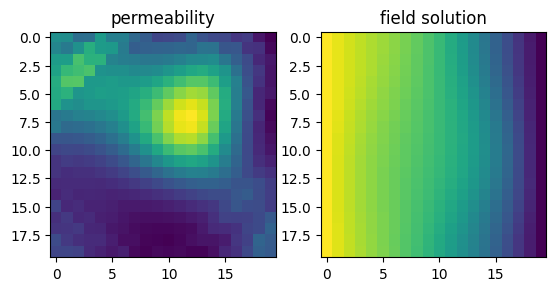

In [3]:
plt.subplot(1, 2, 1)
plt.title('permeability')
plt.imshow(k_train.squeeze(-1).tensor[0])
plt.subplot(1, 2, 2)
plt.title('field solution')
plt.imshow(u_train.squeeze(-1)[0])
plt.show()

We now create the neural operator class. It is a very simple class, inheriting from `AbstractProblem`.

In [ ]:
class NeuralOperatorSolver(AbstractProblem):
    input_variables = k_train.full_labels[3]['dof']
    output_variables = u_train.full_labels[3]['dof']
    conditions = {'data' : Condition(input=k_train, 
                                     target=u_train)}
# make problem
problem = NeuralOperatorSolver()

## Solving the problem with a FeedForward Neural Network

We will first solve the problem using a Feedforward neural network. We will use the `SupervisedSolver` for solving the problem, since we are training using supervised learning.

In [5]:
# make model
model = FeedForward(input_dimensions=1, output_dimensions=1)


# make solver
solver = SupervisedSolver(problem=problem, model=model)

# make the trainer and train
trainer = Trainer(solver=solver, max_epochs=10, accelerator='cpu', enable_model_summary=False, batch_size=10) 
# We train on CPU and avoid model summary at the beginning of training (optional)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 9: 100%|██████████| 70/70 [00:01<00:00, 40.29it/s, v_num=8, data_loss_step=0.103, train_loss_step=0.0993, val_loss_step=0.103, data_loss_epoch=0.105, val_loss_epoch=0.102, train_loss_epoch=0.105]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 70/70 [00:01<00:00, 40.09it/s, v_num=8, data_loss_step=0.103, train_loss_step=0.0993, val_loss_step=0.103, data_loss_epoch=0.105, val_loss_epoch=0.102, train_loss_epoch=0.105]


The final loss is pretty high... We can calculate the error by importing `LpLoss`.

In [6]:
from pina.loss import LpLoss

# make the metric
metric_err = LpLoss(relative=True)

model = solver.model
err = float(metric_err(u_train.squeeze(-1), model(k_train).squeeze(-1)).mean())*100
print(f'Final error training {err:.2f}%')

err = float(metric_err(u_test.squeeze(-1), model(k_test).squeeze(-1)).mean())*100
print(f'Final error testing {err:.2f}%')

Final error training 56.17%
Final error testing 56.07%


## Solving the problem with a Fourier Neural Operator (FNO)

We will now move to solve the problem using a FNO. Since we are learning operator this approach is better suited, as we shall see.

In [7]:
# make model
lifting_net = torch.nn.Linear(1, 24)
projecting_net = torch.nn.Linear(24, 1)
model = FNO(lifting_net=lifting_net,
            projecting_net=projecting_net,
            n_modes=8,
            dimensions=2,
            inner_size=24,
            padding=8)


# make solver
solver = SupervisedSolver(problem=problem, model=model)

# make the trainer and train
trainer = Trainer(solver=solver, max_epochs=10, accelerator='cpu', enable_model_summary=False, batch_size=10) # we train on CPU and avoid model summary at beginning of training (optional)
trainer.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 9: 100%|██████████| 70/70 [00:03<00:00, 20.06it/s, v_num=9, data_loss_step=0.00303, train_loss_step=0.00401, val_loss_step=0.00303, data_loss_epoch=0.00338, val_loss_epoch=0.00363, train_loss_epoch=0.00338]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 70/70 [00:03<00:00, 19.94it/s, v_num=9, data_loss_step=0.00303, train_loss_step=0.00401, val_loss_step=0.00303, data_loss_epoch=0.00338, val_loss_epoch=0.00363, train_loss_epoch=0.00338]


We can clearly see that the final loss is lower. Let's see in testing.. Notice that the number of parameters is way higher than a `FeedForward` network. We suggest to use GPU or TPU for a speed up in training, when many data samples are used.

In [8]:
model = solver.model

err = float(metric_err(u_train.squeeze(-1), model(k_train).squeeze(-1)).mean())*100
print(f'Final error training {err:.2f}%')

err = float(metric_err(u_test.squeeze(-1), model(k_test).squeeze(-1)).mean())*100
print(f'Final error testing {err:.2f}%')

Final error training 9.14%
Final error testing 9.15%


As we can see the loss is way lower!

## What's next?

We have made a very simple example on how to use the `FNO` for learning neural operator. Currently in **PINA** we implement 1D/2D/3D cases. We suggest to extend the tutorial using more complex problems and train for longer, to see the full potential of neural operators.